# < Project Gaea 인공 신경망 >

Project Gaea에서 핵심 역할을 하는 인공 신경망 학습 코드입니다.

## (1) import

In [1]:
#import plaidml.keras
#plaidml.keras.install_backend()

import tensorflow as tf
print(tf.__version__)

from tensorboard.plugins.hparams import api as hp


2.1.0


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import sys
import glob
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from IPython.display import clear_output
from skimage.transform import pyramid_expand


from PIL import Image
import cv2


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [58]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 20

## 추가1. 하이퍼 파라미터 튜닝 변수 선언

In [9]:
g_1 = hp.HParam('g_1', hp.Discrete([32, 64, 128, 256, 512]))
g_2 = hp.HParam('g_2', hp.Discrete([32, 64, 128, 256, 512]))
g_3 = hp.HParam('g_3', hp.Discrete([32, 64, 128, 256, 512]))
g_4 = hp.HParam('g_4', hp.Discrete([32, 64, 128, 256, 512]))
g_5 = hp.HParam('g_5', hp.Discrete([32, 64, 128, 256, 512]))
g_6 = hp.HParam('g_6', hp.Discrete([32, 64, 128, 256, 512]))
g_7 = hp.HParam('g_7', hp.Discrete([32, 64, 128, 256, 512]))
g_8 = hp.HParam('g_8', hp.Discrete([32, 64, 128, 256, 512]))
g_9 = hp.HParam('g_9', hp.Discrete([32, 64, 128, 256, 512]))
g_10 = hp.HParam('g_10', hp.Discrete([32, 64, 128, 256, 512]))
g_11 = hp.HParam('g_11', hp.Discrete([32, 64, 128, 256, 512]))
g_12 = hp.HParam('g_12', hp.Discrete([32, 64, 128, 256, 512]))
g_13 =  hp.HParam('g_13', hp.Discrete([32, 64, 128, 256, 512]))
g_14 = hp.HParam('g_14', hp.Discrete([32, 64, 128, 256, 512]))
g_15 = hp.HParam('g_15', hp.Discrete([32, 64, 128, 256, 512]))
g_k = hp.HParam('g_k', hp.Discrete([4, 9, 16]))

d_1 = hp.HParam('d_1', hp.Discrete([32, 64, 128, 256, 512]))
d_2 = hp.HParam('d_2', hp.Discrete([32, 64, 128, 256, 512]))
d_3 = hp.HParam('d_3', hp.Discrete([32, 64, 128, 256, 512]))
d_4 = hp.HParam('d_4', hp.Discrete([32, 64, 128, 256, 512]))
d_k = hp.HParam('d_k', hp.Discrete([4, 9, 16]))

HP_learning_rate = hp.HParam('learning_rate', hp.Discrete([0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.0]))
HP_lamda = hp.HParam('lamda', hp.Discrete([1, 10, 50, 100, 125, 150]))
HP_dropout = hp.HParam('dropout', hp.Discrete([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs').as_default():
    hp.hparams_config(
    hparams=[g_1, g_2, g_3, g_4, g_5,g_6,g_7,g_8,g_9,g_10,g_11,g_12,g_13,g_14,g_15,g_k,d_1,d_2,d_3,d_4,d_k,HP_learning_rate,HP_lamda, HP_dropout],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')]
  )

## (2) 데이터셋 전처리

In [10]:
#이미지 주어진 크기에 따라 랜덤으로 분할,
def random_crop(image, c=3):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, c])

  return cropped_image

In [11]:
# "-1 <= image <= 1" 로 변환
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [12]:
#이미지 변환 처리 중..
def random_jitter(image, c=3):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image, c=c)

  # random mirroring
  #image = tf.image.random_flip_left_right(image)

  return image

In [13]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [14]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [15]:
def preprocess_image_test_nl(image):
  image = normalize(image)
  return image

In [16]:
def preprocess_image_train_nl(image, c=3):
  image = random_jitter(image, c=c)
  image = normalize(image)
  return image

In [17]:
def similar(n1, n2, d=0):
    sn = abs(n1-n2)
    if sn >= 0 and sn <= d :
        return True
    else :
        return False

In [89]:
class imagedata:
  def __init__(self, path,  w = 128, h = 192, degree=0):
    self.degree=degree
    self.outp = Image.open(path).convert("RGBA")
    
    pix = np.array(self.outp)[0][0]
    img = self.outp
    datas = img.getdata()
    newData = []
    for item in datas:
        if similar(item[0], pix[0], d=self.degree) and similar(item[1], pix[1], d=self.degree) and similar(item[2], pix[2], d=self.degree):
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    self.outp = img
    
    
    
    self.outp = img.resize((w, h))
    area = (0, 0, int(w/4), int(h/4))
    self.inp = self.outp.crop(area)
    
    inp1 = np.array(self.inp)
    inp1 = cv2.cvtColor(inp1, cv2.COLOR_RGB2RGBA)
    inp2 = cv2.vconcat([inp1, inp1, inp1, inp1])
    self.inp = cv2.hconcat([inp2, inp2, inp2, inp2]) 
    
    self.outp = np.array(img)
    self.outp = cv2.cvtColor(self.outp, cv2.COLOR_RGB2RGBA)
    
   # print("인풋 사이즈 : " + str(self.inp.shape))
    #print("아웃풋 사이즈 : " + str(self.outp.shape))
    
    self.inp = preprocess_image_train_nl(self.inp, c=4)
    self.outp = preprocess_image_train_nl(self.outp, c=4)
    
    

In [19]:
'''PATH_DIR='./Dataset/'
filelist = []

for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:
  try :
    filelist.append(imagedata(PATH_DIR + str(i)))
  except :
    print(str(i)+" 파일 로드 실패")
    continue
  print(str(i)+" 파일 로드 완료")'''

'PATH_DIR=\'./Dataset/\'\nfilelist = []\n\nfor i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:\n  try :\n    filelist.append(imagedata(PATH_DIR + str(i)))\n  except :\n    print(str(i)+" 파일 로드 실패")\n    continue\n  print(str(i)+" 파일 로드 완료")'

In [20]:
PATH_DIR='./Dataset/'
filelist = [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]

## (3) Pix2Pix 신경망 구성

In [21]:
OUTPUT_CHANNELS = 4

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
def upsample(filters, size, hparams, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(hparams[HP_dropout]))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
def Generator(hparams):
  inputs = tf.keras.layers.Input(shape=[256,256,4])

  down_stack = [
    downsample(hparams[g_1], hparams[g_k], apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(hparams[g_2], hparams[g_k]), # (bs, 64, 64, 128)
    downsample(hparams[g_3], hparams[g_k]), # (bs, 32, 32, 256)
    downsample(hparams[g_4], hparams[g_k]), # (bs, 16, 16, 512)
    downsample(hparams[g_5],hparams[g_k]), # (bs, 8, 8, 512)
    downsample(hparams[g_6],hparams[g_k]), # (bs,hparams[g_k],hparams[g_k], 512)
    downsample(hparams[g_7],hparams[g_k]), # (bs, 2, 2, 512)
    downsample(hparams[g_8],hparams[g_k]), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(hparams[g_9],hparams[g_k], hparams, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(hparams[g_10],hparams[g_k], hparams, apply_dropout=True), # (bs,hparams[g_k],hparams[g_k], 1024)
    upsample(hparams[g_11],hparams[g_k], hparams, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(hparams[g_12],hparams[g_k], hparams), # (bs, 16, 16, 1024)
    upsample(hparams[g_13],hparams[g_k], hparams), # (bs, 32, 32, 512)
    upsample(hparams[g_14],hparams[g_k], hparams), # (bs, 64, 64, 256)
    upsample(hparams[g_15],hparams[g_k], hparams), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,hparams[g_k],
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [26]:
LAMBDA = None

In [27]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [28]:
def Discriminator(hparams):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 4], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 4], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(hparams[d_1], hparams[d_k], False)(x) # (bs, 128, 128, 64)
  down2 = downsample(hparams[d_2], hparams[d_k])(down1) # (bs, 64, 64, 128)
  down3 = downsample(hparams[d_3], hparams[d_k])(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(hparams[d_4], hparams[d_k], strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, hparams[d_k], strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [31]:
print(1e-4)

0.0001


## (4) 신경망 준비

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.00003, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00003, beta_1=0.5)

## (5) 체크포인트

In [ ]:
checkpoint_dir = './training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True, period=10)

In [ ]:
checkpoint.restore(ckpt_manager.latest_checkpoint)

## (6) 학습 Setting

In [79]:
#학습 횟수
EPOCHS = 1

In [33]:
#이미지를 Generator을 통해서 "여름->겨울"로 변환하는 함수
def generate_images(model, test_input):
  prediction = model(test_input[np.newaxis], training=True)
  test_input1 = cv2.resize(test_input[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  prediction1 = cv2.resize(np.array(prediction[0]), dsize=(128, 192), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(12, 12))


  display_list = [test_input1, prediction1]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  
  plt.show()

In [34]:
#이미지를 Generator을 통해서 "여름->겨울"로 변환하는 함수
def generate_images_r(model, test_input, real_output, e=-1):
  prediction = model(test_input[np.newaxis], training=True)
  test_input1 = cv2.resize(test_input[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  prediction1 = cv2.resize(np.array(prediction[0]), dsize=(128, 192), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(12, 12))


  real_output1 = cv2.resize(real_output[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  display_list = [test_input1, prediction1, real_output1]
  title = ['Input Image', 'Predicted Image', 'Real Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  
  if e > -1 :
    plt.savefig('genimage/Gen{0}.png'.format(e))
  plt.show()
  return prediction1

In [35]:
def sampling(train_x, train_y, batch_size) :
  train_xb = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  train_yb = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  listaa = np.arange(train_x.shape[0])
  listaa = np.random.choice(listaa, batch_size, replace=False)
  for i in listaa:
    train_xb = np.append(train_xb, train_x[i][np.newaxis], axis=0)
    train_yb = np.append(train_yb, train_y[i][np.newaxis], axis=0)
  return train_xb, train_yb

In [105]:
#@tf.function
def train_step(input_image, target):
  global generator, discriminator, generator_gradients, discriminator_gradients
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
  return gen_total_loss

## (7) 학습 함수 구성

In [106]:
#@tf.function
def cal_g_loss(input_image, target, generator, discriminator):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  return gen_total_loss

In [107]:
#@tf.function
def cal_d_loss(input_image, target, generator, discriminator):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  return disc_loss

In [101]:
'''train_x = []
train_y = []

for i in filelist:
  print("인풋 배열 크기 : " + str(i.inp.shape))
  print("아웃풋 배열 크기" + str(i.outp.shape))
  train_x.append(i.inp)
  train_y.append(i.outp)'''

'train_x = []\ntrain_y = []\n\nfor i in filelist:\n  print("인풋 배열 크기 : " + str(i.inp.shape))\n  print("아웃풋 배열 크기" + str(i.outp.shape))\n  train_x.append(i.inp)\n  train_y.append(i.outp)'

In [39]:
from random import sample
import random
def sampling_list(a, b, batch):
  batches = [random.randint(0,len(a)-1) for r in range(0, batch)]
  c = []
  d = []
  for j in batches:
    c.append(a[j])
    d.append(b[j])
  g = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 4], dtype='float32')
  h = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 4], dtype='float32')
  for i in range(0, batch):
    g = np.append(g, c[i][np.newaxis], axis=0)
    h = np.append(h, d[i][np.newaxis], axis=0)
  return g, h

In [40]:
from random import sample
#filelist.append(imagedata(PATH_DIR + str(i)))
def sampling_batch(fl, b, pd='./Dataset/'):
    while True :
        try :
            
            g = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 4], dtype='float32')
            h = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 4], dtype='float32')
            for i in sample(fl,b):
                g = np.append(g, imagedata(pd+str(i)).inp[np.newaxis], axis=0)
                h = np.append(h, imagedata(pd+str(i)).outp[np.newaxis], axis=0)
            return g, h
        except :
            continue

In [41]:
'''train_x = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
train_y = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')

numi = 1
for i in filelist:
  #print("인풋 배열 크기 : " + str(i.inp.shape))
  #print("아웃풋 배열 크기" + str(i.outp.shape))
  #train_x.append(i.inp)
  print(str(numi) + "번째 이미지 로드 중..")
  
  train_x = np.append(train_x, i.inp[np.newaxis], axis=0)
  train_y = np.append(train_y, i.outp[np.newaxis], axis=0)
  
  if train_x.shape[0] % 500 == 0 and train_y.shape[0] % 500 == 0:
    print("================================================================================================================")
    np.save("saved_array/train_x", train_x)
    np.save("saved_array/train_y", train_y)
    f = open("saved_array/textnum.txt", 'w')
    f.write(str(numi))
    f.close()
    
    print("= "+str(numi)+"번쨰 배열 파일 세이브 완료")
    print("================================================================================================================")
  numi = numi + 1
  #train_y.append(i.outp)
    '''

'train_x = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype=\'float32\')\ntrain_y = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype=\'float32\')\n\nnumi = 1\nfor i in filelist:\n  #print("인풋 배열 크기 : " + str(i.inp.shape))\n  #print("아웃풋 배열 크기" + str(i.outp.shape))\n  #train_x.append(i.inp)\n  print(str(numi) + "번째 이미지 로드 중..")\n  \n  train_x = np.append(train_x, i.inp[np.newaxis], axis=0)\n  train_y = np.append(train_y, i.outp[np.newaxis], axis=0)\n  \n  if train_x.shape[0] % 500 == 0 and train_y.shape[0] % 500 == 0:\n    print("================================================================================================================")\n    np.save("saved_array/train_x", train_x)\n    np.save("saved_array/train_y", train_y)\n    f = open("saved_array/textnum.txt", \'w\')\n    f.write(str(numi))\n    f.close()\n    \n    print("= "+str(numi)+"번쨰 배열 파일 세이브 완료")\n    print("========================================================================================================

In [42]:
def readago():
    f = open("saved_loss/textnum5.txt", "r")
    lines = f.read()
    f.close()
    losstrainlist = []
    losstestlist = []
    for i in lines.split("\n"):
        if i == "[losslog]" :
            continue
        losstrainlist.append(float(i.split(":")[1]))
        losstestlist.append(float(i.split(":")[2]))
        
    return losstrainlist, losstestlist

In [43]:
def drawlossg(ll1, ll2, epoch):
    y1 = ll1
    x1 = range(1, len(ll1)+1)
    y2 = ll2
    x2 = range(1, len(ll2)+1)
    
    plt.plot(x1, y1, x2, y2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Loss Graph (Learning : {0})".format(epoch))
    plt.legend(['Train', 'Test'], loc=0)
    plt.show()

In [44]:
def saveloss(epoch, loss1, loss2):
    f = open("saved_loss/textnum5.txt", "a")
    f.write("\n{0}:{1}:{2}".format(str(epoch), str(loss1.numpy()), str(loss2.numpy())))
    f.close()
    return loss1.numpy(), loss2.numpy()

In [45]:
PATH_DIR='./testinput/'
testlist = []
inputlist=[file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]
for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:
  if i in filelist :
    print(str(i)+" 파일  Load fail")
    continue
  try :
    testlist.append(imagedata(PATH_DIR + str(i)))
  except :
    print(str(i)+" 파일 로드 실패")
    continue
  print(str(i)+" 파일 로드 완료")

test_x = []
test_y = []
for i in testlist:
  test_x.append(i.inp)
  test_y.append(i.outp)
#clear_output(wait=True)
print("모든 테스트 이미지 로드 완료")

Chubby (3643).png 파일 로드 완료
Chubby (3644).png 파일 로드 완료
Chubby (3645).png 파일 로드 완료
Chubby (3646).png 파일 로드 완료
Chubby (3647).png 파일 로드 완료
Chubby (3648).png 파일 로드 완료
Chubby (3649).png 파일 로드 완료
Chubby (3650).png 파일 로드 완료
Chubby (3651).png 파일 로드 완료
Chubby (3652).png 파일 로드 완료
Chubby (3653).png 파일 로드 완료
Chubby (3654).png 파일 로드 완료
Chubby (3655).png 파일 로드 완료
Chubby (3656).png 파일 로드 완료
Chubby (3657).png 파일 로드 완료
Chubby (3658).png 파일 로드 완료
Chubby (3659).png 파일 로드 완료
Chubby (3660).png 파일 로드 완료
Chubby (3661).png 파일 로드 완료
Chubby (3662).png 파일 로드 완료
Chubby (3663).png 파일 로드 완료
Chubby (3664).png 파일 로드 완료
Chubby (3665).png 파일 로드 완료
Chubby (3666).png 파일 로드 완료
Chubby (3667).png 파일 로드 완료
Chubby (3668).png 파일 로드 완료
Chubby (3669).png 파일 로드 완료
Chubby (3670).png 파일 로드 완료
Chubby (3671).png 파일 로드 완료
Chubby (3672).png 파일 로드 완료
Chubby (3673).png 파일 로드 완료
Chubby (3674).png 파일 로드 완료
Chubby (3675).png 파일 로드 완료
Chubby (3676).png 파일 로드 완료
Chubby (3677).png 파일 로드 완료
Chubby (3678).png 파일 로드 완료
Chubby (3679).png 파일 로드 완료
C

Chubby (3947).png 파일 로드 완료
Chubby (3948).png 파일 로드 완료
Chubby (3949).png 파일 로드 완료
Chubby (3950).png 파일 로드 완료
Chubby (3951).png 파일 로드 완료
Chubby (3952).png 파일 로드 완료
Render99530.png 파일 로드 완료
Render99531.png 파일 로드 완료
Render99532.png 파일 로드 완료
Render99533.png 파일 로드 완료
Render99534.png 파일 로드 완료
Render99535.png 파일 로드 완료
Render99536.png 파일 로드 완료
Render99537.png 파일 로드 완료
Render99538.png 파일 로드 완료
Render99539.png 파일 로드 완료
Render99540.png 파일 로드 완료
Render99541.png 파일 로드 완료
Render99542.png 파일 로드 완료
Render99543.png 파일 로드 완료
Render99544.png 파일 로드 완료
Render99545.png 파일 로드 완료
Render99546.png 파일 로드 완료
Render99547.png 파일 로드 완료
Render99548.png 파일 로드 완료
Render99549.png 파일 로드 완료
Render99550.png 파일 로드 완료
Render99551.png 파일 로드 완료
Render99552.png 파일 로드 완료
Render99553.png 파일 로드 완료
Render99554.png 파일 로드 완료
Render99555.png 파일 로드 완료
Render99556.png 파일 로드 완료
Render99557.png 파일 로드 완료
Render99558.png 파일 로드 완료
Render99559.png 파일 로드 완료
Render99560.png 파일 로드 완료
Render99561.png 파일 로드 완료
Render99562.png 파일 로드 완료
Render99563.p

In [46]:
def save_model(generator, discriminator, num):
  generator.save('saved_model1/generator{0}.h5'.format(num))
  discriminator.save('saved_model1/discriminator{0}.h5'.format(num))

학습 인풋의 형태 (25, 256, 256, 4)
학습 아웃풋의 형태 (25, 256, 256, 4)


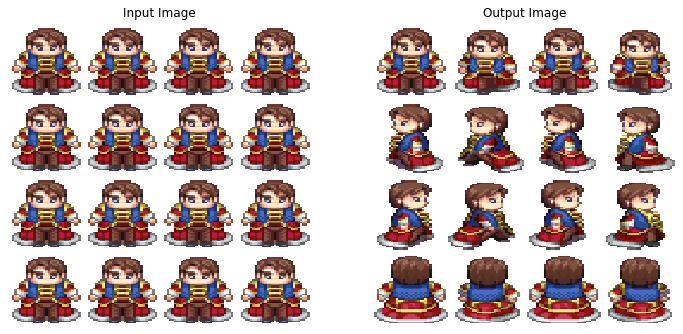

In [49]:

a, b= sampling_batch(filelist, BATCH_SIZE)
print("학습 인풋의 형태 {0}".format(a.shape))
print("학습 아웃풋의 형태 {0}".format(b.shape))
plt.figure(figsize=(12, 12))
cv2.imwrite('gradient/testx.png', (a[0]*0.5+0.5)*255)
cv2.imwrite('gradient/testy.png', (b[0]*0.5+0.5)*255)

display_list = [a[0], b[0]]
title = ['Input Image', 'Output Image']
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])
  plt.imshow(display_list[i] * 0.5 + 0.5)
  plt.axis('off')
plt.show()

In [108]:
def testall(ge, di):
    PATH_DIR='./testinput2/'
    testlist2 = []
    inputlist=[file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".PNG") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]
    for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".PNG") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:
      if i in filelist :
        print(str(i)+" 파일  Load fail")
        continue
      try :
        testlist2.append(imagedata(PATH_DIR + str(i)))
      except :
        print(str(i)+" 파일 로드 실패")
        continue
      #print(str(i)+" 파일 로드 완료")

    test_x2 = []
    test_y2 = []
    for i in testlist2:
      test_x2.append(i.inp)
      test_y2.append(i.outp)
    #print("모든 테스트 이미지 로드 완료")

    c, d = sampling_list(test_x2, test_y2, 3)

    model = generator #tf.keras.models.load_model("saved_model/generator4.h5")
    #cv2.imwrite('rinptt.png', (cv2.cvtColor(np.array(testlist2[1].inp), cv2.COLOR_BGR2RGBA)*0.5+0.5)*255)
    
    lossg = 0.0
    lossg+=cal_g_loss(c[0][np.newaxis], d[0][np.newaxis], ge, di)
    lossg+=cal_g_loss(c[1][np.newaxis], d[1][np.newaxis], ge, di)
    lossg+=cal_g_loss(c[2][np.newaxis], d[2][np.newaxis], ge, di)
    
    lossd = 0.0
    lossd+=cal_d_loss(c[0][np.newaxis], d[0][np.newaxis], ge, di)
    lossd+=cal_d_loss(c[1][np.newaxis], d[1][np.newaxis], ge, di)
    lossd+=cal_d_loss(c[2][np.newaxis], d[2][np.newaxis], ge, di)
    
    return lossg, lossd

## (8) 학습 시작

In [109]:
generator = None
discriminator = None
generator_optimizer = None
discriminator_optimizer = None

def trainging(num, hparams):
    global generator, discriminator, generator_optimizer, discriminator_optimizer
    with tf.summary.create_file_writer('logs/'+str(num)).as_default():
        generator = Generator(hparams)
        discriminator = Discriminator(hparams)

        generator_optimizer = tf.keras.optimizers.Adam(hparams[HP_learning_rate], beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(hparams[HP_learning_rate], beta_1=0.5)

        for epoch in range(0, EPOCHS):
          a, b = sampling_batch(filelist, BATCH_SIZE, pd='./Dataset/')
          c, d = sampling_list(test_x, test_y, 1)
          
          for n in range(0, BATCH_SIZE):
              losstrain = train_step(a[n][np.newaxis], b[n][np.newaxis])
          print("[{0}번째 튜닝] {1}번째 학습 완료".format(num, epoch))
        
        save_model(generator, discriminator, num)
        _lg, _ld = testall(generator, discriminator)
        tf.summary.scalar(METRIC_ACCURACY, _lg + _ld, step=1)
        return _lg, _ld

In [110]:
session_num=0
max_session=100
for _ in range(max_session):
    hparams = {
        g_1: random.choice(g_1.domain.values),
        g_2: random.choice(g_2.domain.values),
        g_3: random.choice(g_3.domain.values),
        g_4: random.choice(g_4.domain.values),
        g_5: random.choice(g_5.domain.values),
        g_6: random.choice(g_6.domain.values),
        g_7: random.choice(g_7.domain.values),
        g_8: random.choice(g_8.domain.values),
        g_9: random.choice(g_9.domain.values),
        g_10: random.choice(g_10.domain.values),
        g_11: random.choice(g_11.domain.values),
        g_12: random.choice(g_12.domain.values),
        g_13: random.choice(g_13.domain.values),
        g_14: random.choice(g_14.domain.values),
        g_15: random.choice(g_15.domain.values),
        g_k: random.choice(g_k.domain.values),
        d_1: random.choice(d_1.domain.values),
        d_2: random.choice(d_2.domain.values),
        d_3: random.choice(d_3.domain.values),
        d_4: random.choice(d_4.domain.values),
        d_k: random.choice(d_k.domain.values),
        HP_learning_rate: random.choice(HP_learning_rate.domain.values),
        HP_lamda: random.choice(HP_lamda.domain.values),
        HP_dropout: random.choice(HP_dropout.domain.values),
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    LAMBDA = hparams[HP_lamda]
    _lg, _ld = trainging(session_num, hparams)
    print("G 손실 : {0} & D 손실 : {1}\n\n".format(_lg, _ld))
    session_num += 1

--- Starting trial: run-0
{'g_1': 128, 'g_2': 256, 'g_3': 512, 'g_4': 256, 'g_5': 512, 'g_6': 32, 'g_7': 128, 'g_8': 32, 'g_9': 64, 'g_10': 64, 'g_11': 128, 'g_12': 256, 'g_13': 512, 'g_14': 64, 'g_15': 256, 'g_k': 4, 'd_1': 128, 'd_2': 256, 'd_3': 32, 'd_4': 256, 'd_k': 9, 'learning_rate': 0.0005, 'lamda': 125, 'dropout': 0.4}
[0번째 튜닝] 0번째 학습 완료
aa.png 파일 로드 완료
dataset.png 파일 로드 완료
아르시스.PNG 파일 로드 완료
모든 테스트 이미지 로드 완료
G 손실 : 88.79035949707031 & D 손실 : 5.06636905670166


--- Starting trial: run-1
{'g_1': 128, 'g_2': 512, 'g_3': 64, 'g_4': 32, 'g_5': 512, 'g_6': 512, 'g_7': 512, 'g_8': 32, 'g_9': 64, 'g_10': 128, 'g_11': 256, 'g_12': 32, 'g_13': 512, 'g_14': 128, 'g_15': 64, 'g_k': 16, 'd_1': 64, 'd_2': 64, 'd_3': 128, 'd_4': 512, 'd_k': 9, 'learning_rate': 0.005, 'lamda': 1, 'dropout': 0.2}


KeyboardInterrupt: 

## (9) Model 저장

In [ ]:
generator_g.save('saved_model/generator_g', save_format='tf')
print("generator_g 저장 완료")
generator_f.save('saved_model/generator_f', save_format='tf')
print("generator_f 저장 완료")
discriminator_x.save('saved_model/discriminator_x', save_format='tf')
print("discriminator_x 저장 완료")
discriminator_y.save('saved_model/discriminator_y', save_format='tf')
print("discriminator_y 저장 완료")

aa.png 파일 로드 완료
dataset.png 파일 로드 완료
아르시스.PNG 파일 로드 완료
모든 테스트 이미지 로드 완료


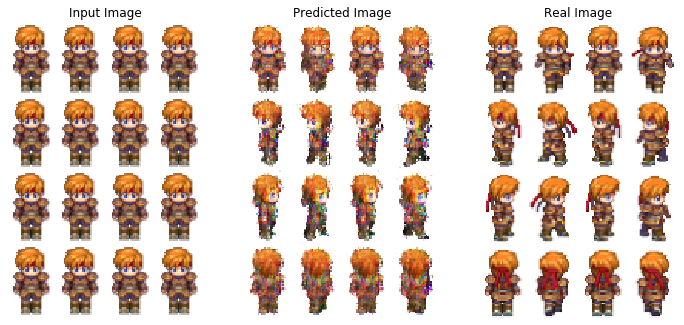

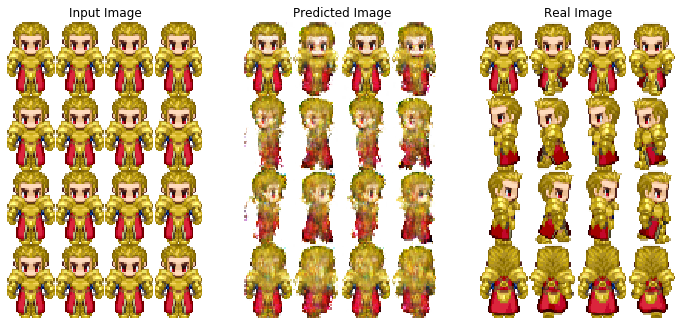

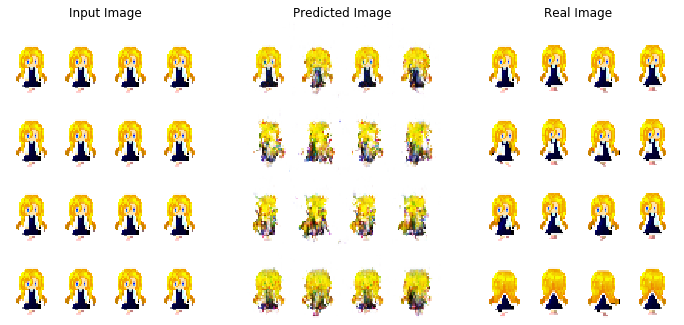

array([[[ 0.99998933,  0.99993014,  0.9999756 , -1.        ],
        [ 0.99989027,  0.9998584 ,  0.99995226, -0.99999994],
        [ 0.9999881 ,  0.9999515 ,  0.9999565 , -0.99999994],
        ...,
        [ 0.99999964,  0.99999857,  0.999999  , -1.        ],
        [ 0.99999976,  0.9999988 ,  0.99999905, -1.        ],
        [ 0.9999958 ,  0.99999666,  0.99999756, -1.        ]],

       [[ 1.        ,  1.        ,  1.        , -1.        ],
        [ 0.9999933 ,  0.99999034,  0.99999964, -1.        ],
        [ 1.        ,  1.        ,  1.        , -1.        ],
        ...,
        [ 0.99999964,  0.99999964,  0.9999999 , -1.        ],
        [ 0.99999976,  0.99999994,  0.99999994, -1.        ],
        [ 1.        ,  1.        ,  1.        , -1.        ]],

       [[ 0.9999975 ,  0.99999225,  0.99999964, -1.        ],
        [ 0.99998647,  0.9999924 ,  0.99999976, -1.        ],
        [ 0.99988914,  0.9999553 ,  0.999932  , -0.99999994],
        ...,
        [ 0.99999994,  0.99

In [59]:
PATH_DIR='./testinput2/'
testlist2 = []
inputlist=[file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".PNG") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]
for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".PNG") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:
  if i in filelist :
    print(str(i)+" 파일  Load fail")
    continue
  try :
    testlist2.append(imagedata(PATH_DIR + str(i)))
  except :
    print(str(i)+" 파일 로드 실패")
    continue
  print(str(i)+" 파일 로드 완료")

test_x2 = []
test_y2 = []
for i in testlist2:
  test_x2.append(i.inp)
  test_y2.append(i.outp)
print("모든 테스트 이미지 로드 완료")

c, d = sampling_list(test_x2, test_y2, 3)

model = generator #tf.keras.models.load_model("saved_model/generator4.h5")
#cv2.imwrite('rinptt.png', (cv2.cvtColor(np.array(testlist2[1].inp), cv2.COLOR_BGR2RGBA)*0.5+0.5)*255)
generate_images_r(model, c[0], d[0])
generate_images_r(model, c[1], d[1])
generate_images_r(model, c[2], d[2])

aa.png 파일 로드 완료
dataset.png 파일 로드 완료
아르시스.PNG 파일 로드 완료
모든 테스트 이미지 로드 완료


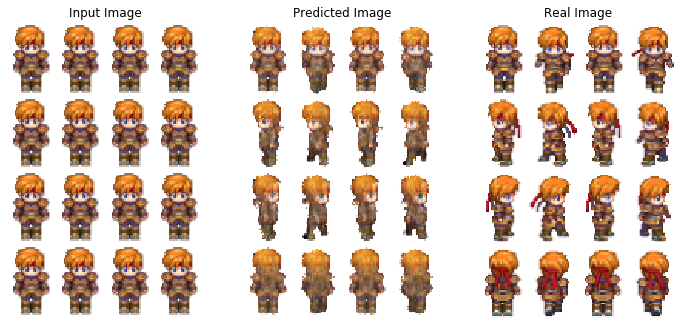

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


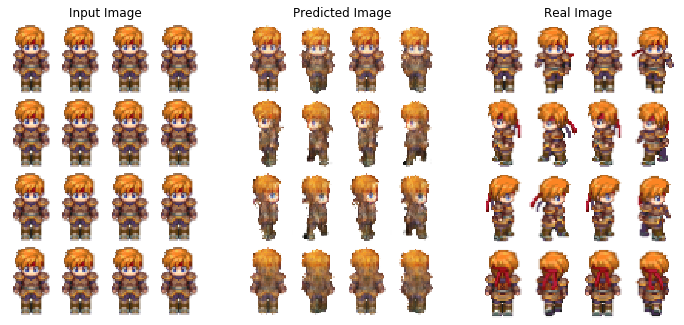

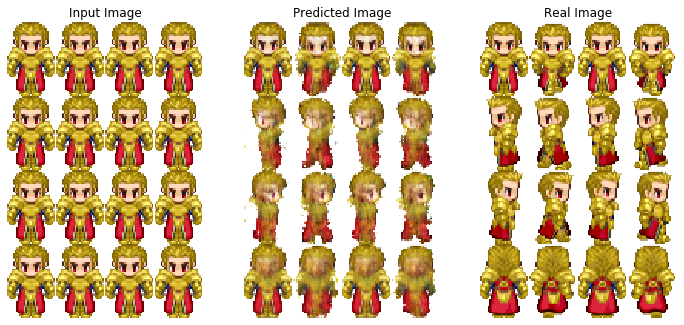

array([[[ 0.9999393 ,  0.9999629 ,  0.99999106, -0.99999994],
        [ 0.9999576 ,  0.9999854 ,  0.99998534, -1.        ],
        [ 0.99999905,  0.9999994 ,  0.9999989 , -1.        ],
        ...,
        [ 1.        ,  1.        ,  1.        , -1.        ],
        [ 1.        ,  1.        ,  1.        , -1.        ],
        [ 0.9999995 ,  0.9999997 ,  0.99999964, -1.        ]],

       [[ 0.9999014 ,  0.99993896,  0.9999896 , -1.        ],
        [ 0.999921  ,  0.99999386,  0.9999938 , -1.        ],
        [ 1.        ,  1.        ,  1.        , -1.        ],
        ...,
        [ 1.        ,  1.        ,  1.        , -1.        ],
        [ 1.        ,  1.        ,  1.        , -1.        ],
        [ 1.        ,  1.        ,  1.        , -1.        ]],

       [[ 0.9999627 ,  0.999962  ,  0.999992  , -1.        ],
        [ 0.9999862 ,  0.9999995 ,  0.99999976, -1.        ],
        [ 1.        ,  1.        ,  1.        , -1.        ],
        ...,
        [ 1.        ,  1.  

In [63]:
PATH_DIR='./testinput2/'
testlist2 = []
inputlist=[file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".PNG") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]
for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".PNG") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:
  if i in filelist :
    print(str(i)+" 파일  Load fail")
    continue
  try :
    testlist2.append(imagedata(PATH_DIR + str(i)))
  except :
    print(str(i)+" 파일 로드 실패")
    continue
  print(str(i)+" 파일 로드 완료")

test_x2 = []
test_y2 = []
for i in testlist2:
  test_x2.append(i.inp)
  test_y2.append(i.outp)
print("모든 테스트 이미지 로드 완료")

c, d = sampling_list(test_x2, test_y2, 3)

model = tf.keras.models.load_model("saved_model/1st save/generator4.h5")
#cv2.imwrite('rinptt.png', (cv2.cvtColor(np.array(testlist2[1].inp), cv2.COLOR_BGR2RGBA)*0.5+0.5)*255)
generate_images_r(model, c[0], d[0])
generate_images_r(model, c[1], d[1])
generate_images_r(model, c[2], d[2])

In [ ]:
model = tf.keras.models.load_model('saved_model/generator_g')
generate_images_r(model, train_x[0], train_y[0])

In [177]:
save_model(generator, discriminator)

In [58]:
generator.save('saved_model/generator_final.h5')
discriminator.save('saved_model/discriminator_final.h5')

In [ ]:
import numpy as np
import tensorflow as tf

# Load the MobileNet tf.keras model.
model = tf.keras.applications.MobileNetV2(
    weights="imagenet", input_shape=(224, 224, 3))

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
tflite_results = interpreter.get_tensor(output_details[0]['index'])

# Test the TensorFlow model on random input data.
tf_results = model(tf.constant(input_data))

# Compare the result.
for tf_result, tflite_result in zip(tf_results, tflite_results):
  np.testing.assert_almost_equal(tf_result, tflite_result, decimal=5)